# Table of Contents


- **Geting Started**
    - Set Up Environment
    - Import Data
- **ModelSearcher**
    - Define Models & Hyper Parameters to Serach
    - Create/Run the ModelSearcher object
    - Evaluate

Note: this notebook is meant to be a demo of some of the capabilities of **`oo-learning`** (https://github.com/shane-kercheval/oo-learning); it is not meant to show the best approach to exploring/cleaning/modeling this particular dataset. Also, with most graphs (e.g. correlations/box-plots/etc.) I will spend very little time commenting on the significance of any interesting or patterns. Again, the intent is to show a demo, not a guide to data analysis. 



# Getting Started

In this notebook, we'll see how to search across different models and hyper-parameters (or the same models and hyper-parameters with different transformations, for example) with the goal of finding the "best" or ideal model candidates for further tuning and optimization.

## Set Up Environment

In [1]:
# !pip install oolearning --upgrade

In [2]:
from oolearning import *
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline
pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
width = 10
plt.rcParams['figure.figsize'] = [width, width/1.333]

## Import Data

`ExploreRegressionDataset` is a convenience class described in the [first notebook of this series](https://github.com/shane-kercheval/oo-learning/blob/master/examples/regression-insurance/1-Exploring.ipynb).

In [3]:
csv_file = '../data/insurance.csv'
target_variable = 'expenses'

explore = ExploreRegressionDataset.from_csv(csv_file_path=csv_file,
                                                target_variable=target_variable)

In [4]:
explore.dataset.head()

,age,sex,bmi,children,smoker,region,expenses
0,19,female,27.9,0,yes,southwest,16884.92
1,18,male,33.8,1,no,southeast,1725.55
2,28,male,33.0,3,no,southeast,4449.46
3,33,male,22.7,0,no,northwest,21984.47
4,32,male,28.9,0,no,northwest,3866.86


# `ModelSearcher`

A "Searcher" searches across different models and hyper-parameters (or the same models and hyper-parameters with different transformations, for example) with the goal of finding the "best" or ideal model candidates for further tuning and optimization.

We'll supply the searcher with ModelInfo objects, for each model, encapsulates a description, a model object, hyper-param object, and a grid of hyper parameter values to evaluate.  

The data is split (via a Splitter) into training and holding sets. The training set will be used for selecting the "best" hyper parameters via (Tuner & Resampler) and then the model will be retrained and evaluated with selected hyper parameters with the holdout set.

## Define Models & Hyper Parameters to Serach

Below we define the information necessary to search **`Ridge`**, **`Lasso`**, and **`Elastic Net`** models, across various hyper parameters.

In [5]:
# define the models and hyper-parameters that we want to search through
infos = [ModelInfo(description='Ridge Regression',
                   model=RidgeRegressor(),
                   # transformations specific to this model
                   transformations=None,
                   hyper_params=RidgeRegressorHP(),
                   hyper_params_grid=HyperParamsGrid(params_dict=dict(alpha=[0, 0.01, 0.1, 1]))),
        ModelInfo(description='Lasso Regression',
                   model=LassoRegressor(),
                   # transformations specific to this model
                   transformations=None,
                   hyper_params=LassoRegressorHP(),
                   hyper_params_grid=HyperParamsGrid(params_dict=dict(alpha=[0, 0.01, 0.1, 1]))),
        ModelInfo(description='Elastic Net Regression',
                   model=ElasticNetRegressor(),
                   # transformations specific to this model
                   transformations=None,
                   hyper_params=ElasticNetRegressorHP(),
                   hyper_params_grid=HyperParamsGrid(params_dict=dict(alpha=[0.01, 0.1, 1],
                                                                      l1_ratio=[0, 0.5, 1])))]


Here are the hyper-parameter combinations we will try out for each of the models.

In [6]:
infos[0].hyper_params_grid.params_grid

,alpha
0,0.00
1,0.01
2,0.10
3,1.00


In [7]:
infos[1].hyper_params_grid.params_grid

,alpha
0,0.00
1,0.01
2,0.10
3,1.00


In [8]:
infos[2].hyper_params_grid.params_grid

,alpha,l1_ratio
0,0.01,0.0
1,0.01,0.5
2,0.01,1.0
3,0.10,0.0
4,0.10,0.5
5,0.10,1.0
6,1.00,0.0
7,1.00,0.5
8,1.00,1.0


## Create/Run the ModelSearcher object

In [9]:
searcher = ModelSearcher(global_transformations=[DummyEncodeTransformer(CategoricalEncoding.DUMMY)],
                         model_infos=infos,
                         splitter=RegressionStratifiedDataSplitter(holdout_ratio=0.25),
                         resampler_function=lambda m, mt: RepeatedCrossValidationResampler(
                             model=m,
                             transformations=mt,
                             scores=[MaeScore(), RmseScore()],
                             folds=5,
                             repeats=3))
searcher.search(data=explore.dataset, target_variable='expenses')

/Users/shanekercheval/anaconda3/lib/python3.6/site-packages/oolearning/model_wrappers/LassoRegressor.py:53: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  ridge_reg.fit(data_x, data_y)
/Users/shanekercheval/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:477: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/Users/shanekercheval/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


## Evaluate

We have access to the **model descriptions** and **model names**.

In [10]:
searcher.results.model_descriptions

['Ridge Regression', 'Lasso Regression', 'Elastic Net Regression']

In [11]:
searcher.results.model_names

['RidgeRegressor', 'LassoRegressor', 'ElasticNetRegressor']

### Resampling Scores


The following plot shows the resampling (AUC) scores for the **best** hyper-parameter combination found, per model.

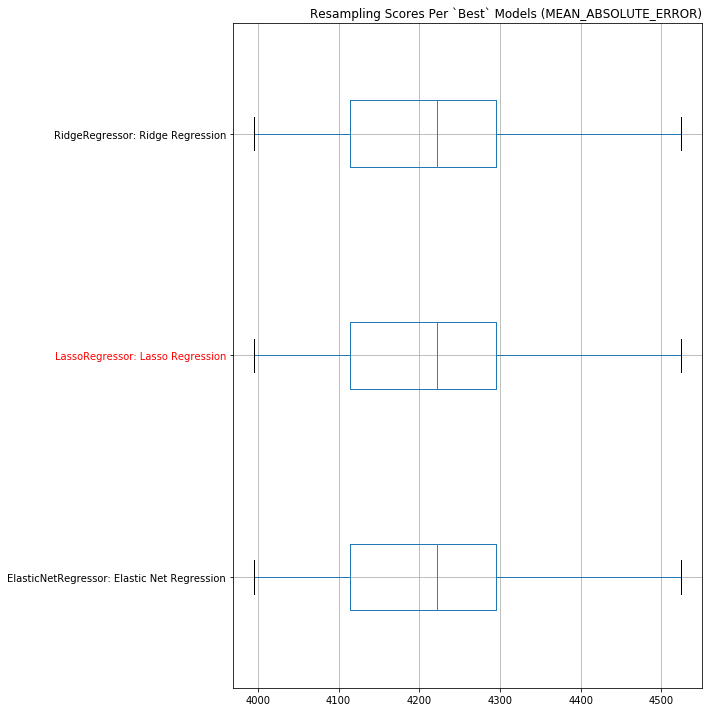

In [12]:
searcher.results.plot_resampled_scores(metric=Metric.MEAN_ABSOLUTE_ERROR)

The following plot shows the resampling (Sensitivity) scores for the **best** hyper-parameter combination found, per model.

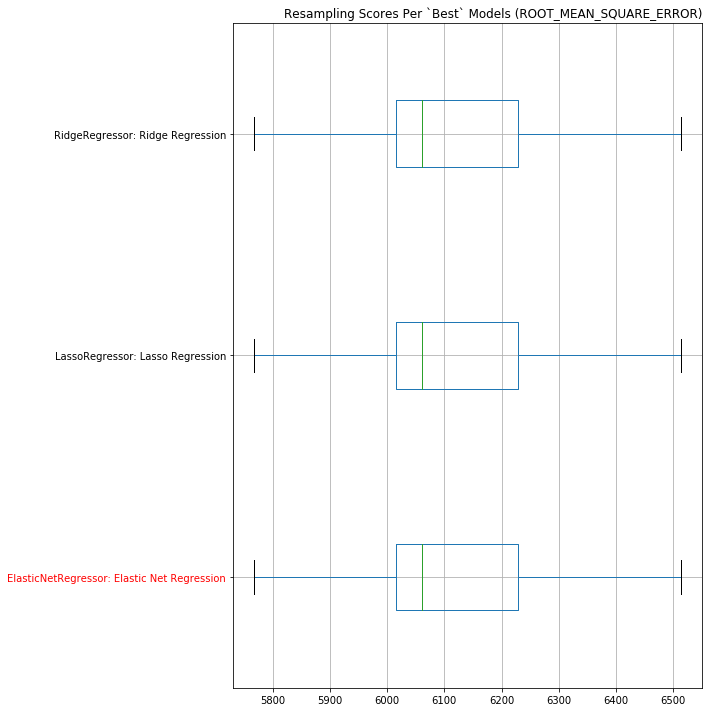

In [13]:
searcher.results.plot_resampled_scores(metric=Metric.ROOT_MEAN_SQUARE_ERROR)

### Holdout Scores

Once the best hyper-parameters for a given model are found via the Resampler, the model and hyper-params are fit on the entire training set and evaluated on the holdout set.

We have access to these holdout scores via the following methods.

In [15]:
searcher.results.holdout_scores

,MAE,RMSE
Ridge Regression,4158.369155,6013.297627
Lasso Regression,4158.369155,6013.297627
Elastic Net Regression,4158.369516,6013.292858


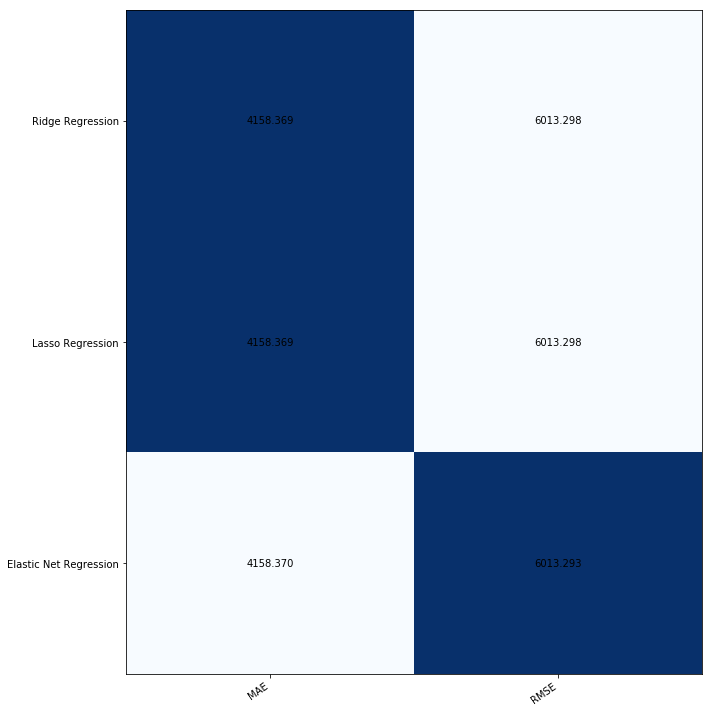

In [16]:
searcher.results.plot_holdout_scores()

In [17]:
searcher.results.best_model_index

0

In [18]:
searcher.results.model_descriptions[searcher.results.best_model_index]

'Ridge Regression'

### Digging into Tuner & Resampler Results

We can access the underlying tuner results for each model via the **`tuner_results`** property.

This s useful because we will rarely pick the best hyper-parameters, so we'll want to see the areas where a particular model does better and try more granular hyper parameter values in those areas.

Let's access the tuner results for the `Elastic Net` model, and see how each hyper-parameter combination performed via the resampling results.

In [19]:
searcher.results.model_names

['RidgeRegressor', 'LassoRegressor', 'ElasticNetRegressor']

In [25]:
en_tuner_results = searcher.results.tuner_results[2]

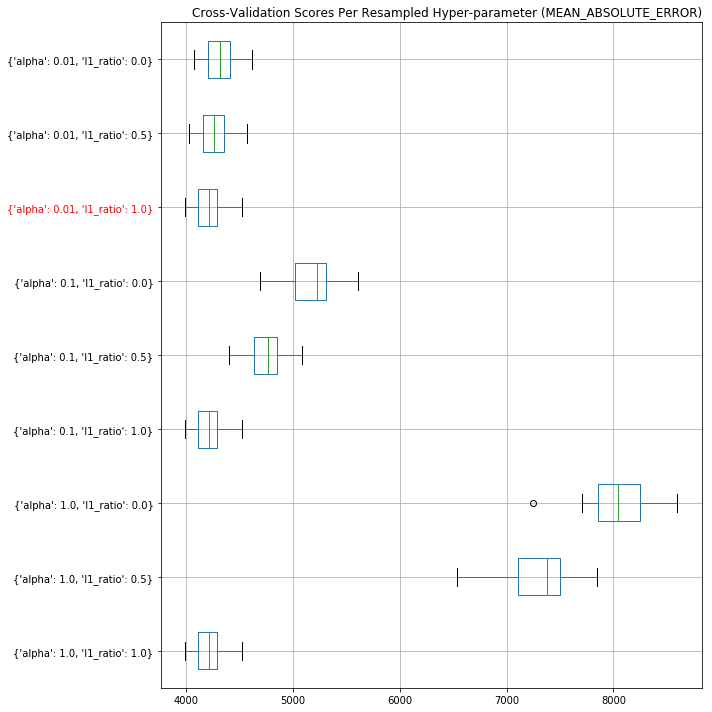

In [26]:
en_tuner_results.plot_resampled_scores(metric=Metric.MEAN_ABSOLUTE_ERROR)

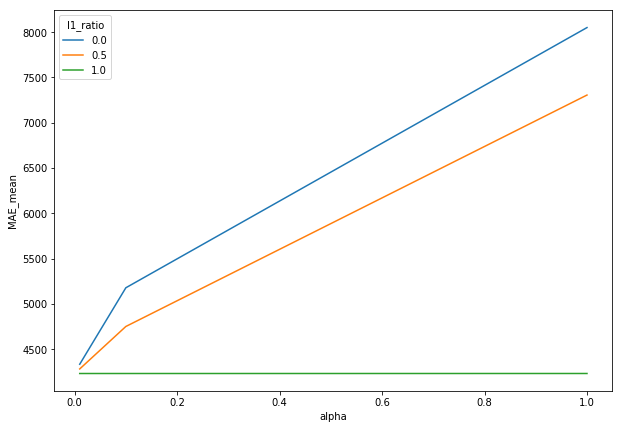

In [27]:
en_tuner_results.plot_hyper_params_profile(metric=Metric.MEAN_ABSOLUTE_ERROR,
                                           x_axis='alpha',
                                           line='l1_ratio')

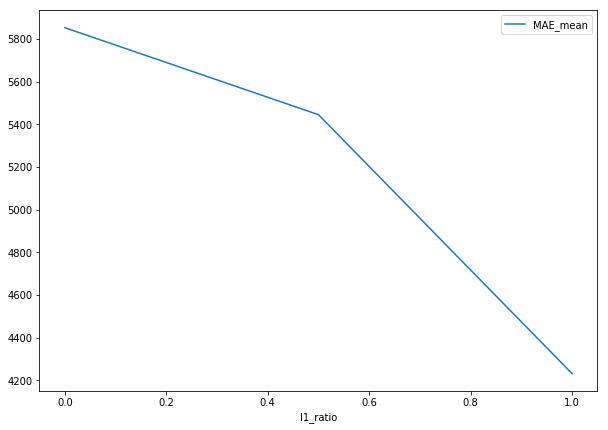

In [28]:
en_tuner_results.plot_hyper_params_profile(metric=Metric.MEAN_ABSOLUTE_ERROR, x_axis='l1_ratio')

In [29]:
searcher.results.tuner_results[0].